# Example 1. SBMs on simulated data

Here we demonstrate how VIRGMo can be used to fit different SBMs to the synthetic data produced from the same model.

In [2]:
import torch
import numpy as np
np.set_printoptions(precision=2)
import pandas as pd
import matplotlib.pyplot as plt
from virgmo.vi_sbm import VI_SBM, VI_DCSBM
from virgmo.graph_models import SBM, DCSBM, EdgesDataset
import seaborn as sns
sns.reset_orig()
torch.manual_seed(42)

## SBM

We start with the standard SBM and unweighted directed graphs. First, we generate a graph with 3 classes of nodes.

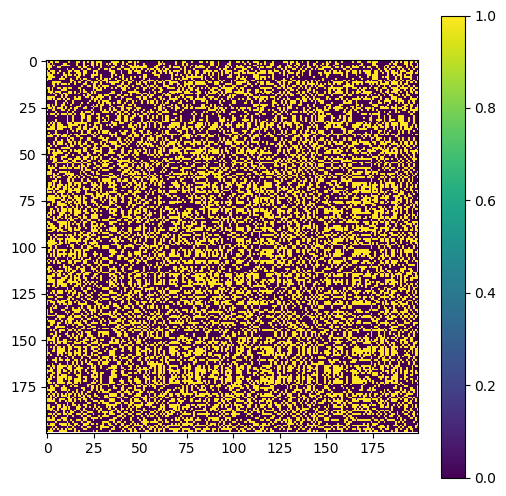

In [3]:
N = 200                              # Number of nodes
num_classes = 3                      # Number of classes
p = torch.tensor([0.2, 0.3, 0.5])    # Probability of each class
B = torch.tensor([                   # Connection probability between classes
        [0.8, 0.1, 0.3],
        [0.1, 0.9, 0.1],
        [0.5, 0.1, 0.8]])
sbm = SBM(p, B)
z, A = sbm.generate(N)               # Generate the class assignments z and the adjacency matrix A
sbm.show(sorted=False)               # Show A

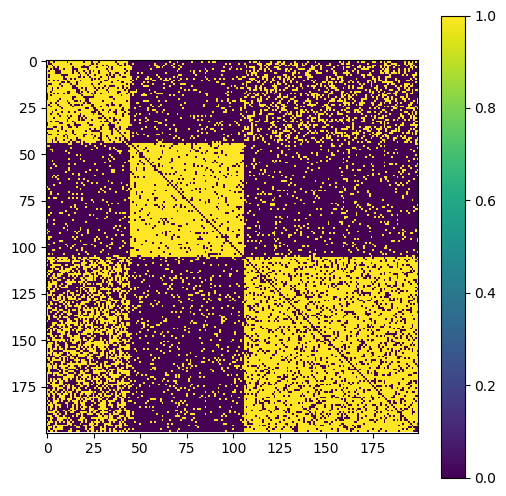

In [4]:
sbm.show(sorted=True)    # Show A sorted by class

Next, we create a dataloader that transformes the adjacency matrix into a set of (start node, finish node, weight) tupels, fit the SBM to the generated data and show the summary.

>>>>>>>>>>>> Start training...
Epoch 1 | LR: 0.10 | Total loss: 29627.47 | Epoch time 1.10
Epoch 2 | LR: 0.10 | Total loss: 25461.48 | Epoch time 1.08
Epoch 3 | LR: 0.10 | Total loss: 24189.60 | Epoch time 0.97
Epoch 4 | LR: 0.10 | Total loss: 23685.23 | Epoch time 1.22
Epoch 5 | LR: 0.10 | Total loss: 23162.39 | Epoch time 1.14
Epoch 6 | LR: 0.10 | Total loss: 21891.89 | Epoch time 0.68
Epoch 7 | LR: 0.10 | Total loss: 19719.02 | Epoch time 1.21
Epoch 8 | LR: 0.10 | Total loss: 18802.11 | Epoch time 0.98
Epoch 9 | LR: 0.10 | Total loss: 18559.09 | Epoch time 0.89
Epoch 10 | LR: 0.10 | Total loss: 18466.76 | Epoch time 0.85
Epoch 11 | LR: 0.10 | Total loss: 18429.09 | Epoch time 0.82
Epoch 12 | LR: 0.10 | Total loss: 18404.59 | Epoch time 0.98
Epoch 13 | LR: 0.10 | Total loss: 18386.81 | Epoch time 0.87
Epoch 14 | LR: 0.10 | Total loss: 18372.35 | Epoch time 0.95
Epoch 15 | LR: 0.10 | Total loss: 18359.70 | Epoch time 0.84
Epoch 16 | LR: 0.10 | Total loss: 18353.80 | Epoch time 0.83
Ep

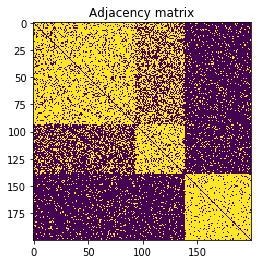

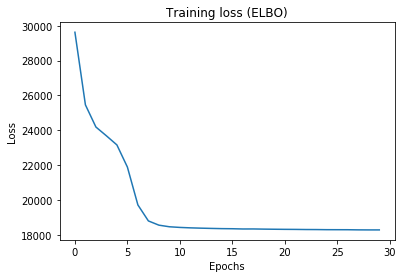

Latent class accuracy: 1.0
Classes probability [0.45 0.23 0.32]
Edges probability:
 [[0.79 0.5  0.11]
 [0.31 0.78 0.12]
 [0.1  0.11 0.88]]


In [5]:
dataloader = DataLoader(EdgesDataset(A), batch_size=N, shuffle=True, num_workers=0)
vi = VI_SBM(num_nodes=N, num_classes=num_classes)
vi.train(dataloader, epochs=30, lrs=0.1)
vi.summary(A, z)

Usually, the this amount of training is enough to find correctly all class assignments and parameter estimations. Let us look precisely on the variational distributions of the class probabilities $\theta$ and connection probabilities $B$. Note, that SBMs are exchangable, i.e. the order of classes is unimportant, although we use a permutation to demonstrate how the posterior covers the true values.

In [6]:
q_eta, q_theta, q_B = vi.constrained_params()    # Get the parameters

In [7]:
permutation = [1,2,0]  # You may have to change the permutation
q_theta_perm = q_theta.detach()[permutation]
num_samples = 1000
theta_samples = Dirichlet(q_theta_perm).sample([num_samples])

In [8]:
sns.set()

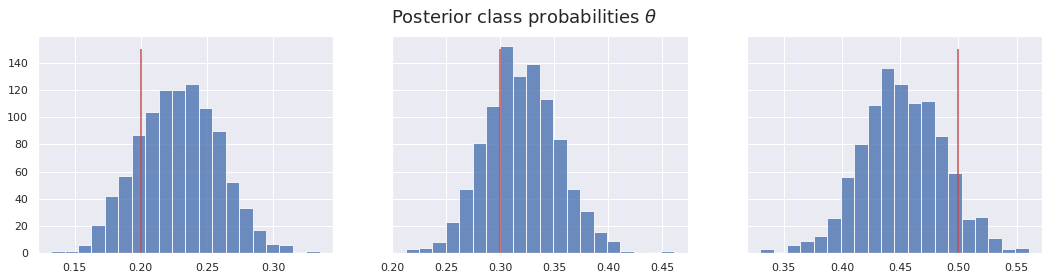

In [9]:
fig, axs = plt.subplots(1, num_classes, figsize=(18,4), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    axs[i].hist(theta_samples[:,i], bins=bins, alpha=alpha) 
    axs[i].vlines(p[i], 0, num_samples*0.15, colors='r')
fig.suptitle(r'Posterior class probabilities $\theta$', fontsize=18)
#plt.savefig('../examples/images/ex1_theta_sbm.pdf')
plt.show()

In [10]:
q_B_perm = q_B.detach()[permutation,:,:][:,permutation,:]
B_samples = Beta(q_B_perm[:,:,0], q_B_perm[:,:,1]).sample([num_samples])

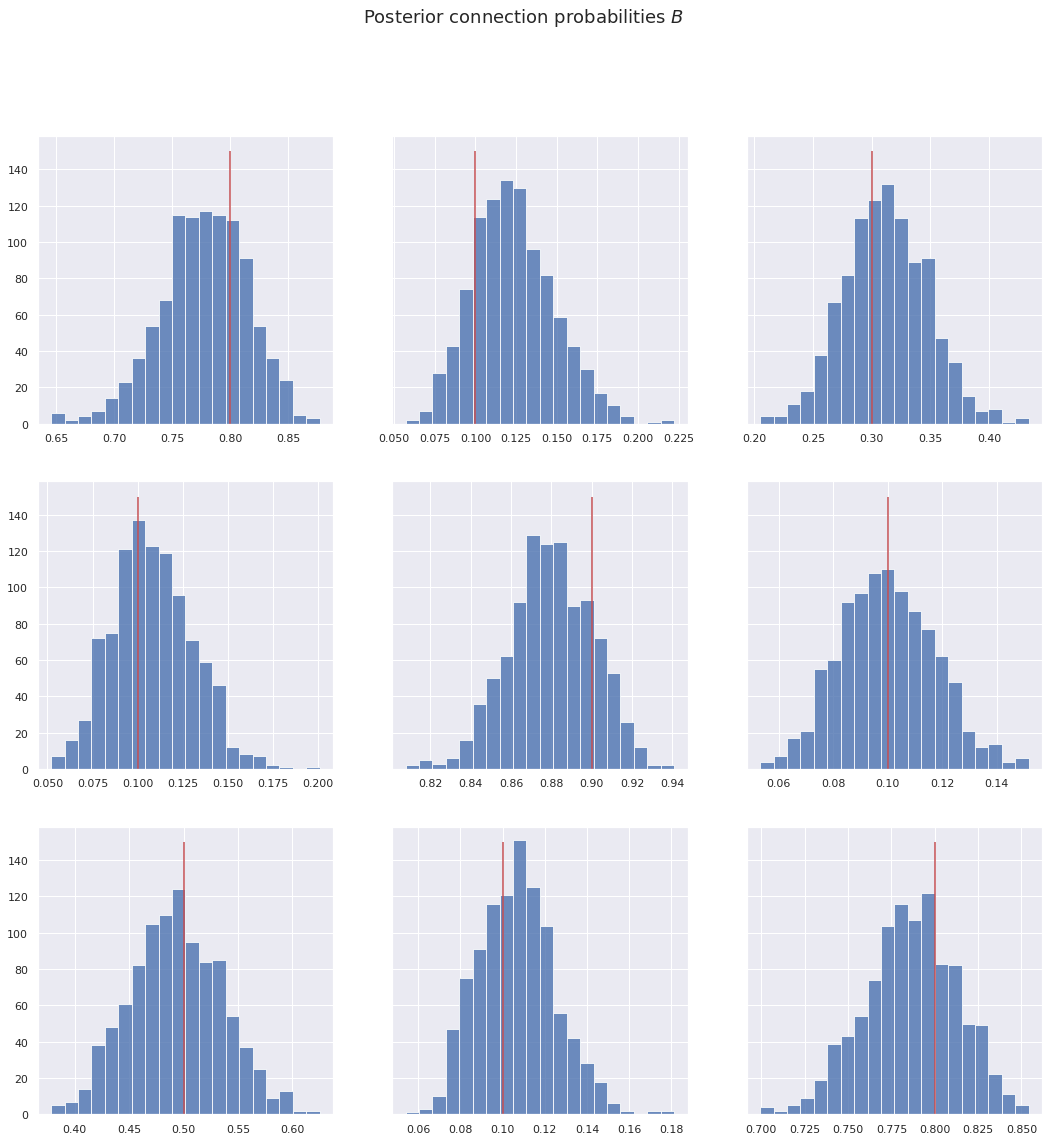

In [11]:
fig, axs = plt.subplots(num_classes, num_classes, figsize=(18,18), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    for j in range(num_classes):
        axs[i,j].hist(B_samples[:,i, j], bins=bins, alpha=alpha) 
        axs[i,j].vlines(B[i,j], 0, num_samples*0.15, colors='r')
fig.suptitle(r'Posterior connection probabilities $B$', fontsize=18)
#plt.savefig('../examples/images/ex1_B_sbm.pdf')
plt.show()

The geometry of the posterior distribution can be very complex and include many local optimas, therefore, the results of the training often depend on the initial state. To confront this problem, we may perforf several training trials with random initialization and choose the best one.

In [12]:
vi.multi_train(dataloader, lrs=0.1, epochs=30, trials=10)

>>>>>>> Start multi-training...
>>> Trial 1/10 | Final loss: 23123.44 | Trial time 33.08
>>> Trial 2/10 | Final loss: 18290.12 | Trial time 32.51
>>> Trial 3/10 | Final loss: 23114.78 | Trial time 55.09
>>> Trial 4/10 | Final loss: 18279.09 | Trial time 50.16
>>> Trial 5/10 | Final loss: 18290.90 | Trial time 46.18
>>> Trial 6/10 | Final loss: 19864.90 | Trial time 51.39
>>> Trial 7/10 | Final loss: 18288.23 | Trial time 54.50
>>> Trial 8/10 | Final loss: 23119.48 | Trial time 48.45
>>> Trial 9/10 | Final loss: 18283.71 | Trial time 52.55
>>> Trial 10/10 | Final loss: 18285.18 | Trial time 54.57


In [13]:
best_trial = vi.get_multi_losses()[:,-1].argmin()   # With the smallest loss ar the end

In [14]:
vi.load_state_dict(vi.state_dicts[best_trial])      # Load the parameters from the best trial
q_eta, q_theta, q_B = vi.constrained_params()

In [31]:
vi.multi_results[1][best_trial]                     # Chose the correct permutation

tensor([0.4560, 0.3514, 0.1926])

In [16]:
permutation = [0,1,2]
q_theta_perm = q_theta.detach()[permutation]
num_samples = 1000
theta_samples = Dirichlet(q_theta_perm).sample([num_samples])

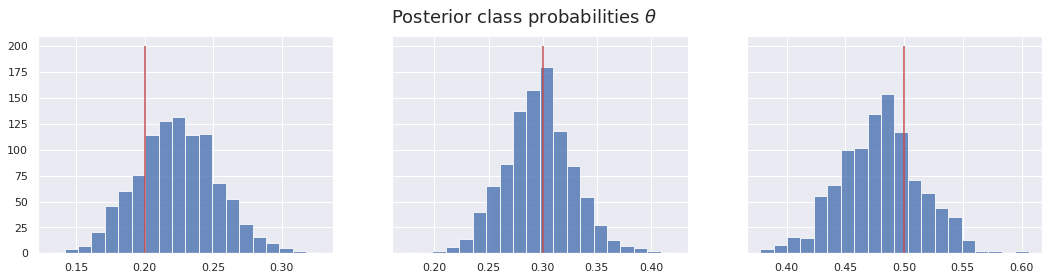

In [17]:
fig, axs = plt.subplots(1, num_classes, figsize=(18,4), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    axs[i].hist(theta_samples[:,i], bins=bins, alpha=alpha) 
    axs[i].vlines(p[i], 0, num_samples*0.2, colors='r')
fig.suptitle(r'Posterior class probabilities $\theta$', fontsize=18)
#plt.savefig('../examples/images/ex1_theta_sbm.pdf')
plt.show()

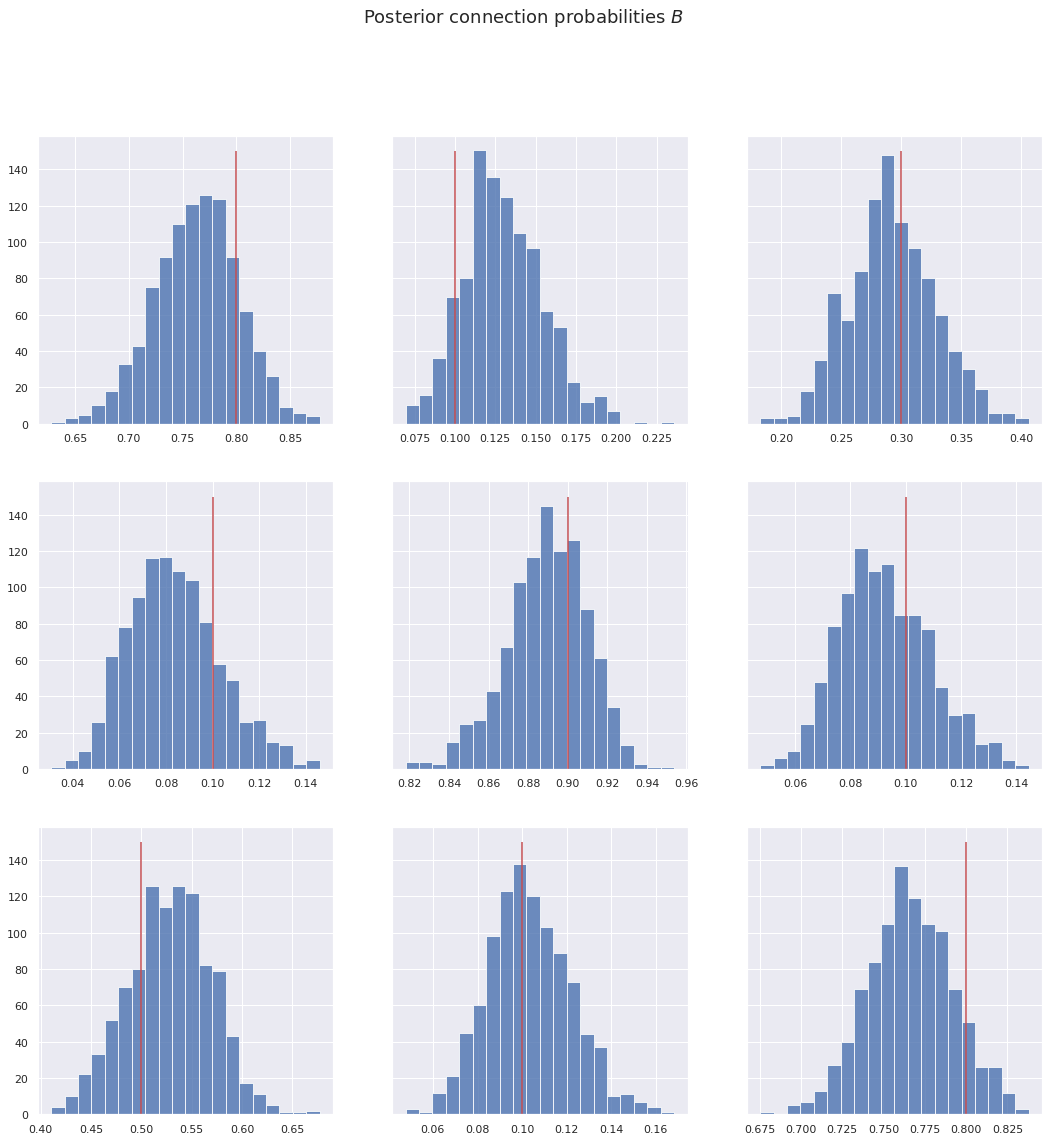

In [18]:
q_B_perm = q_B.detach()[permutation,:,:][:,permutation,:]
B_samples = Beta(q_B_perm[:,:,0], q_B_perm[:,:,1]).sample([num_samples])

fig, axs = plt.subplots(num_classes, num_classes, figsize=(18,18), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    for j in range(num_classes):
        axs[i,j].hist(B_samples[:,i, j], bins=bins, alpha=alpha) 
        axs[i,j].vlines(B[i,j], 0, num_samples*0.15, colors='r')
fig.suptitle(r'Posterior connection probabilities $B$', fontsize=18)
#plt.savefig('../examples/images/ex1_B_sbm.pdf')
plt.show()

--------------------

## DCSBM

Next, let us try the DCSBM

In [19]:
sns.reset_orig()
torch.manual_seed(55)

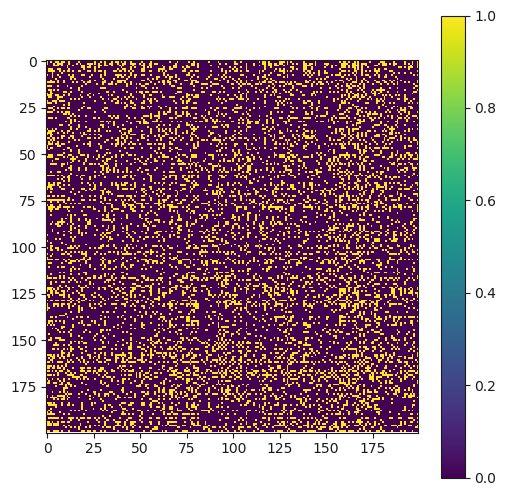

In [20]:
N = 200                              # Number of nodes
num_classes = 3                      # Number of classes
p = torch.tensor([0.2, 0.3, 0.5])    # Probability of each class
B = torch.tensor([                   # Connection probability between classes
        [0.8, 0.1, 0.3],
        [0.1, 0.9, 0.1],
        [0.5, 0.1, 0.8]])
delta = torch.tensor(
    [[0.,1.], [0.,1.], [0.,1.]])     # Parameters of degree distributions
dcsbm = DCSBM(p, B, delta)
z, A = dcsbm.generate(N)             # Generate the class assignments z and the adjacency matrix A
dcsbm.show(sorted=False)             # Show A

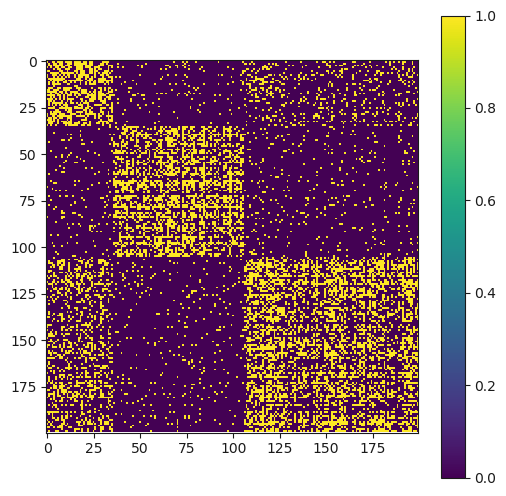

In [21]:
dcsbm.show(sorted=True)    # Show A sorted by class

It is advatagious to initialize the VI with the observed degree distributions. We found this heuristic quite successfull but one should check that it does not produce infinite values.

In [23]:
delta_init = torch.ones([N,2])
delta_mu = A.sum(dim=1)/A.sum(dim=1).mean()
delta_init[:,0]=delta_mu.log().clone()
print('Contains infinities:', bool(torch.isinf(delta_init).sum().item()))

Contains infinities: False


Note, that `train` and `multi_train` methods support training with the chainging learning rate (LR) and the user can specify `lrs` as a list of rates. In this case, `epochs` can be a list of epochs for each LR or an integer then all LRs are used for the same number of epochs.

In [24]:
dataloader = DataLoader(EdgesDataset(A), batch_size=N, shuffle=True, num_workers=0)
vi = VI_DCSBM(num_nodes=N, num_classes=num_classes,
             init_values={'etas':None, 
                          'thetas':None, 
                          'Bs':None, 
                          'deltas':delta_init})
vi.multi_train(dataloader, lrs=[0.1, 0.01], epochs=[30, 10], trials=10)

>>>>>>> Start multi-training...
>>> Trial 1/10 | Final loss: 16532.06 | Trial time 103.15
>>> Trial 2/10 | Final loss: 19764.52 | Trial time 96.12
>>> Trial 3/10 | Final loss: 19763.46 | Trial time 100.59
>>> Trial 4/10 | Final loss: 19764.14 | Trial time 104.48
>>> Trial 5/10 | Final loss: 19764.51 | Trial time 111.78
>>> Trial 6/10 | Final loss: 19763.51 | Trial time 127.35
>>> Trial 7/10 | Final loss: 19764.51 | Trial time 125.24
>>> Trial 8/10 | Final loss: 19762.40 | Trial time 139.67
>>> Trial 9/10 | Final loss: 19762.72 | Trial time 142.77
>>> Trial 10/10 | Final loss: 19759.36 | Trial time 141.09


In [25]:
best_trial = vi.get_multi_losses()[:,-1].argmin()   # With the smallest loss ar the end

In [26]:
vi.load_state_dict(vi.state_dicts[best_trial])      # Load the parameters from the best trial
q_eta, q_theta, q_B, q_delta = vi.constrained_params()

In [27]:
vi.multi_results[1][best_trial]                     # Chose the correct permutation

tensor([0.4560, 0.3514, 0.1926])

In [28]:
permutation = [2,1,0]
q_theta_perm = q_theta.detach()[permutation]
num_samples = 1000
theta_samples = Dirichlet(q_theta_perm).sample([num_samples])

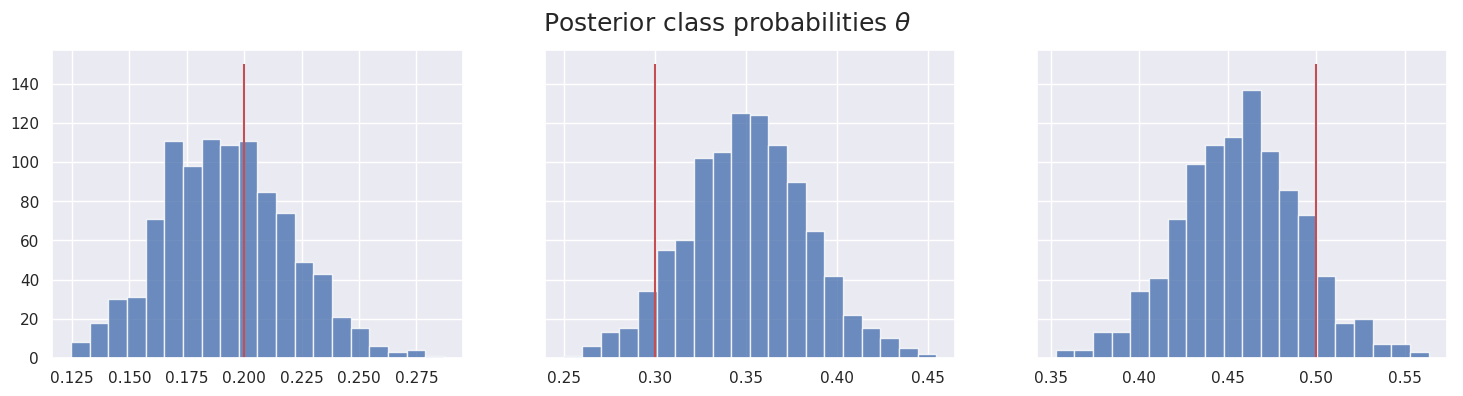

In [29]:
sns.set()
fig, axs = plt.subplots(1, num_classes, figsize=(18,4), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    axs[i].hist(theta_samples[:,i], bins=bins, alpha=alpha) 
    axs[i].vlines(p[i], 0, num_samples*0.15, colors='r')
fig.suptitle(r'Posterior class probabilities $\theta$', fontsize=18)
#plt.savefig('../examples/images/ex1_theta_dcsbm.pdf')
plt.show()

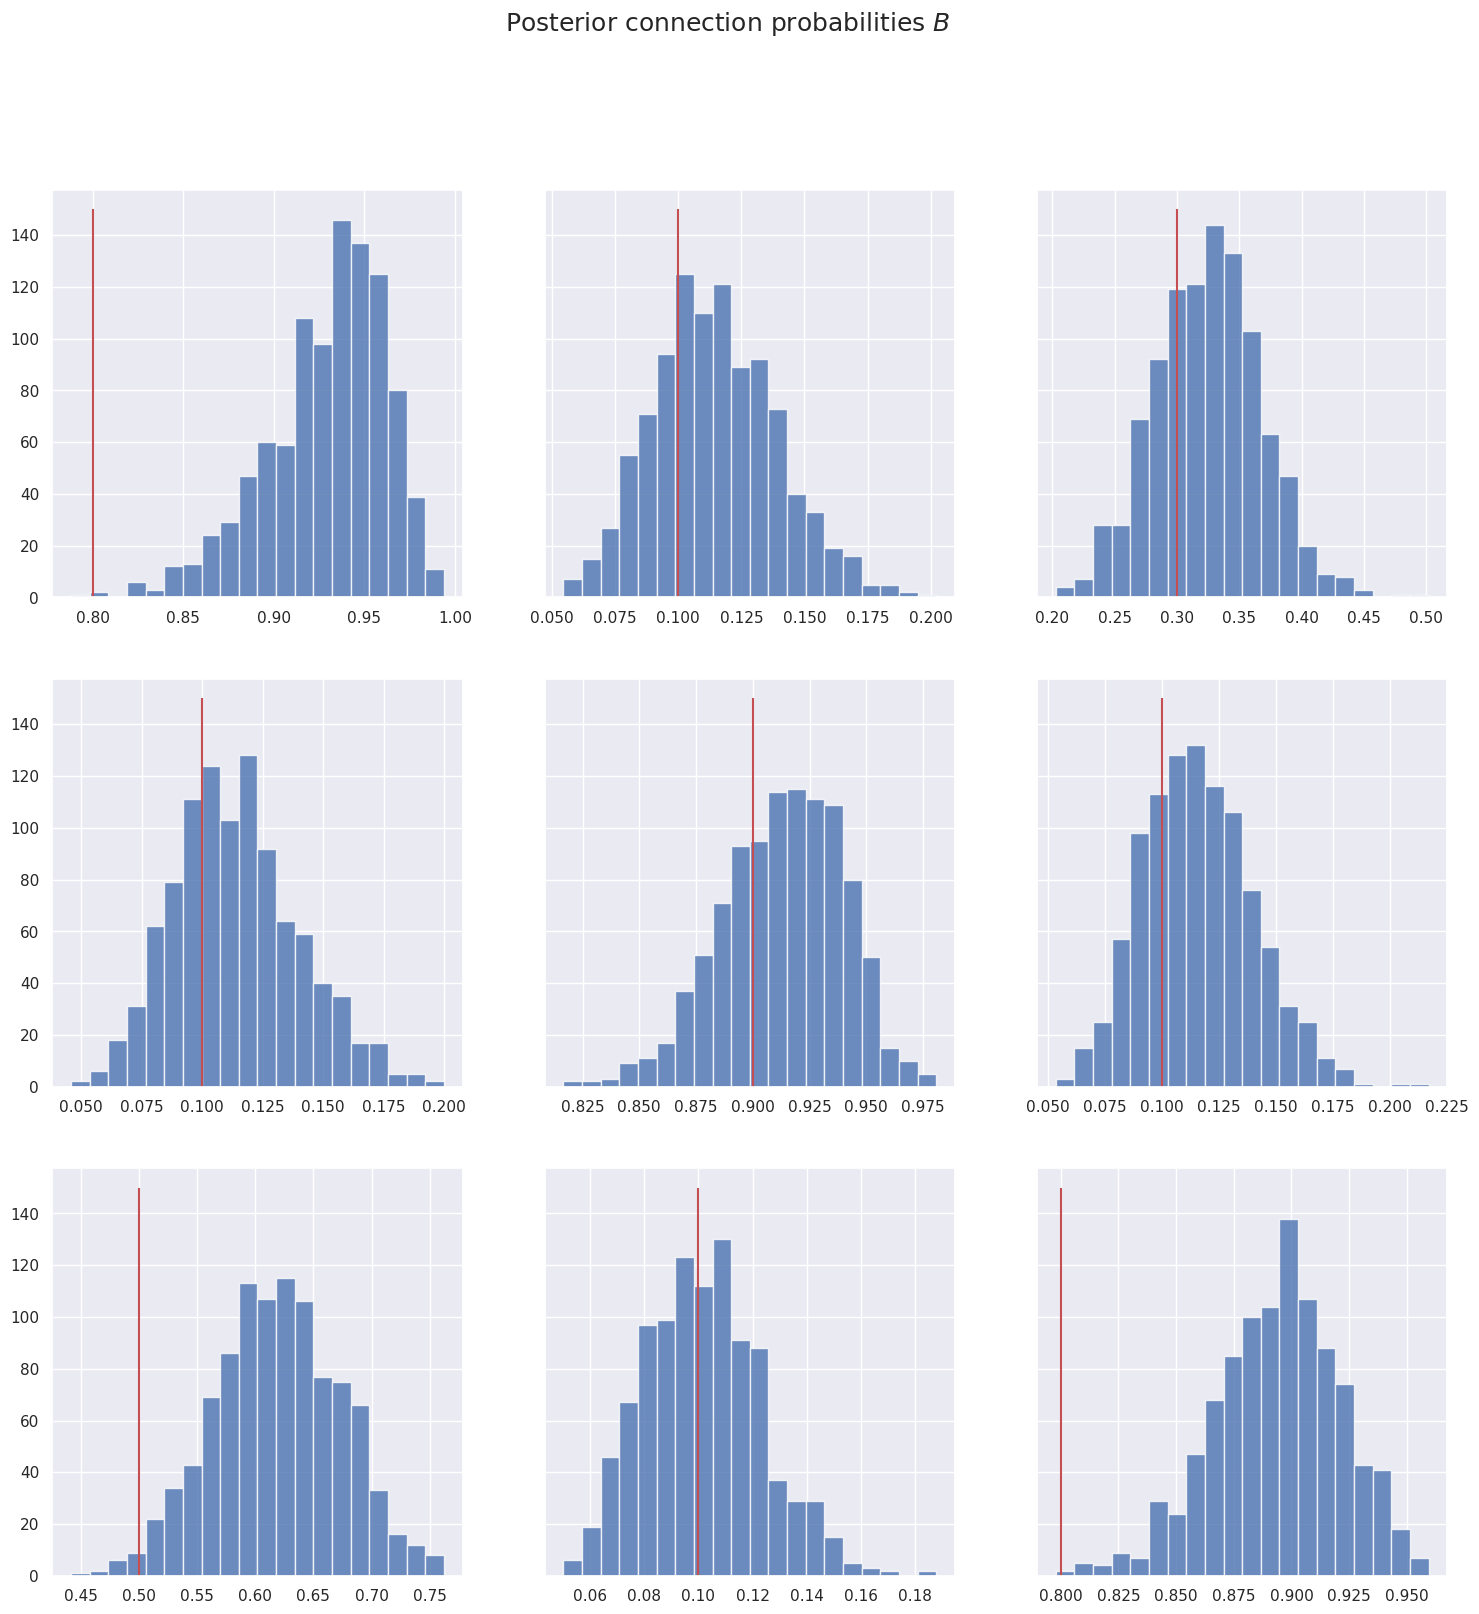

In [30]:
q_B_perm = q_B.detach()[permutation,:,:][:,permutation,:]
B_samples = Beta(q_B_perm[:,:,0], q_B_perm[:,:,1]).sample([num_samples])

fig, axs = plt.subplots(num_classes, num_classes, figsize=(18,18), sharey=True)
bins, alpha = 20, 0.8
for i in range(num_classes):
    for j in range(num_classes):
        axs[i,j].hist(B_samples[:,i, j], bins=bins, alpha=alpha) 
        axs[i,j].vlines(B[i,j], 0, num_samples*0.15, colors='r')
fig.suptitle(r'Posterior connection probabilities $B$', fontsize=18)
#plt.savefig('../examples/images/ex1_B_dcsbm.pdf')
plt.show()